In [141]:
import numpy as np
import pandas as pd
import os
import csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler

from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## EXTRACT DATA
CSV file to be present in local machine.<br>
FIle name is data.csv

In [3]:
data = []
with open('data.csv', 'r') as csvfile: 
    reader = csv.reader(csvfile, skipinitialspace=True)
    data.append(tuple(next(reader)))
    for ID, SMILE, B, RES, is_active in reader:
        data.append((ID, SMILE, B, RES, is_active))

# remove header
data = data[1:]
maxlen = len(data)
print('Number of entries processed: ', maxlen)

Number of entries processed:  29537


In [4]:
# Get only the SMILES data
SMILES = []
for i in data:
    SMILES.append(i[1])

In [5]:
SMILES[0:2]

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C ',
 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O ']

## ONE-HOT ENCODING OF SMILES
This will help in vectrorizing smiles data.<br>
This section will use the tokenizer function that is provided in tensorflow, and we will use keras as the front-end to access the function.<br>
Credit: https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles <br>
Inspiration: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

In [31]:
# Create a tokenizer for vectorization. 
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(SMILES)
# Encoding text_to_sequences
sequences = tokenizer.texts_to_sequences(SMILES)
pad_data = pad_sequences(sequences, maxlen=maxlen)
print ('Encoded string:',pad_data[0])

Encoded string: [ 0  0  0 ...  4  2 10]


In [7]:
#sequences_to_text decodes
print ('Decoded string:',tokenizer.sequences_to_texts(pad_data[0:1]))

Decoded string: ['c 1 ( c 2 c ( [ n H ] c 1 ) c c c ( c 2 ) O C c 1 c c c c c 1 ) C N ( C ) C  ']


In [8]:
def decodeOH2SMILES(array, tokenizer):
    # Converts one-hot encoded sequences back to SMILES strings.
    output = tokenizer.sequences_to_texts(array)
    #Modify this if you change the start or end token.
    disallowed_characters = 'E! '
    for character in disallowed_characters:
        output = [i.replace(character,'') for i in output]
    return output

In [9]:
decoded_smiles = decodeOH2SMILES(pad_data[0:2],tokenizer)
print(decoded_smiles)

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C', 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O']


## MOLECULAR FINGERPRINT ENCODING OF SMILES
This will help in converting smiles data so that it can be used for applying ML techniques. This is more often used (from surveying)<br>
Credit: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

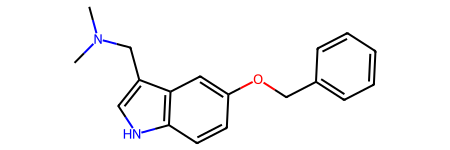

In [109]:
# Drawing molecules
mol = Chem.MolFromSmiles(SMILES[0])
mol

In [112]:
# We will be using RDK fingerprint to vectorize all our SMILES structures
fingerprints = []
for i in range(len(SMILES)):
    mol = Chem.MolFromSmiles(SMILES[i])
    fingerprint_rdk = np.array(RDKFingerprint(mol))
    fingerprints.append(fingerprint_rdk)
fingerprints = np.array(fingerprints)
fingerprints

[20:09:52] WARNING: not removing hydrogen atom without neighbors


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [190]:
print("Number of features =",fingerprints.shape[1])

Number of features = 2048


## VISUALIZATION OF DATA
Data is obtained from the following paper - https://doi.org/10.1371/journal.pcbi.1010613 <br>
In this paper (and a previous paper of theirs), they conducted a series of HTS to obtain the Average B-score and residual values for a series of small molecules to see their potency against Burkholderia cenocepacia.<br>
Quoting the paper,<br>

"The dataset used in the ML approach consisted of 29,537 compounds with residual growth (RG) values and average B-scores. The RG measures the ratio of bacterial growth in the presence and absence of the compounds. The B-score measures relative potency that adjusts the RG for any screening artifacts resulting from well position (row and column) in the assay plate during the HTS. The B-score is inversely proportional to compound potency, where negative B-scores indicate greater growth inhibitory activity of the compounds. To binarize the compounds, the previously established average B-score threshold of -17.5 was chosen [https://doi.org/10.1371/journal.pone.0128587]. Overall, 256 small molecules were classified as growth inhibitory."

Staying true to the essence of the paper, we will be setting a threshold of -17.5 for B-score in our data as well, i.e. below this threshold, the compound is labeled active, and otherwise inactive.

In [50]:
# Checking data for number of active compounds
# idx - ID, SMILE, B, RES, is_active
count = 0
for i in range(len(data)):
    if float(data[i][2]) <= -17.5:
        if float(data[i][4]) == 1:
            count += 1
print("Number of active compounds =",count)
# This follows what is mentioned in the paper.

Number of active compounds = 256


In [154]:
# Get the B-score values
Bscores = []
active = []
is_active = []
for i in range(len(data)):
    Bscores.append(float(data[i][2]))
    is_active.append(float(data[i][4]))
    if float(data[i][4]) == 0:
        active.append("Inactive")
    else:
         active.append("Active")   
compound_idx = np.arange(len(Bscores))
is_active = np.array(is_active)

[Text(0.5, 0, 'Compound Index'), Text(0, 0.5, 'B-Score')]

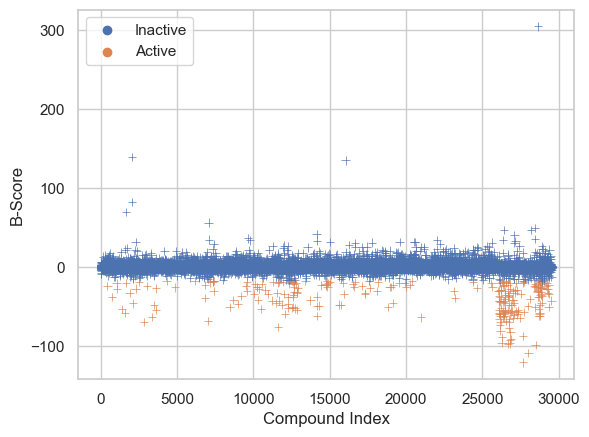

In [63]:
# Visualizing data
# Plot B-scores
fig, ax = plt.subplots()
# plt.scatter(compound_idx[0:100], Bscores[0:100], c ="blue")
sns.set(style='whitegrid')
sns.scatterplot(x=compound_idx,
                    y=Bscores,
                    hue=active, marker='+')
# ax.set_ylim(-500, 100)
ax.set(xlabel='Compound Index', ylabel='B-Score')

## SPLITTING OF DATA
This is an important section because our data is heavily unbalanced. Therefore, we do random undersampling of the major class.


In [155]:
# Includes undersampling of major label to make classes balanced.
def train_test_split(fingerprints, active, split_ratio=0.8):
    rus = RandomUnderSampler() # to make it reproducible -- random_state=rng
    X_resampled, y_resampled = rus.fit_resample(fingerprints, active)
    
    # split data
    # get random permutations
    rand_idx = np.random.permutation(len(X_resampled))
    train_size = round(len(X_resampled)*split_ratio)
    trainX = X_resampled[rand_idx[0:train_size]]
    testX = X_resampled[rand_idx[train_size:len(X_resampled)]]
    trainY = y_resampled[rand_idx[0:train_size]]
    testY = y_resampled[rand_idx[train_size:len(X_resampled)]]
    
    return trainX, trainY, testX, testY

In [156]:
trainX, trainY, testX, testY = train_test_split(fingerprints, is_active)

In [157]:
print("Number of active compounds in:")
print("Train Set = ", sum(trainY == 1))
print("Test Set = ", sum(testY == 1))

print("Number of inactive compounds in:")
print("Train Set = ", sum(trainY == 0))
print("Test Set = ", sum(testY == 0))

Number of active compounds in:
Train Set =  211
Test Set =  45
Number of inactive compounds in:
Train Set =  199
Test Set =  57


## IMPLEMENTING LOGISTIC REGRESSION ON MOLECULAR FINGERPRINTS
Logistic regression will be our base learner for this project. Below is the passive learning implementation for the same.

In [181]:
class LogR():
    def __init__(self, x, y):
        self.trainX = x
        self.trainY = y.reshape(len(y),)
        self.model = LogisticRegression(random_state=0, max_iter=500)
    def fit(self):
        self.model.fit(self.trainX, self.trainY)
    def predict(self, x):
        return self.model.predict(x)
#     def predict_prob(self, x):
#         return self.model.predict_proba(x)
#     def predict_logprob(self, x):
#         return self.model.predict_log_proba(x)
    def generate_acc(self, pred, true):
        return accuracy_score(true, pred)

In [182]:
model = LogR(trainX, trainY)
model.fit()
y_pred = model.predict(testX)

In [183]:
model.generate_acc(y_pred, testY)

0.6274509803921569

In [186]:
# Run multiple simulations since we are sampling the dataset for train-test-split
acc = []
for simulations in range(100):
    trainX, trainY, testX, testY = train_test_split(fingerprints, is_active)
    model = LogR(trainX, trainY)
    model.fit()
    y_pred = model.predict(testX)
    acc.append(model.generate_acc(y_pred, testY))


In [187]:
avg_acc = np.mean(acc)
acc_std = np.std(acc)

In [188]:
print("The average accuracy over all simulations =", avg_acc)
print("The standard deviation over all simulations =", acc_std)

The average accuracy over all simulations = 0.7148039215686275
The standard deviation over all simulations = 0.040401079349573495
